# SST Climatology

From the SST dataset, create monthly averages and monthly anoms, and reproject onto the south polar stereo / EPSG 3976

In [1]:
#directory paths
_work_dir='/g/data/gv90/as2285/miz/'
_data_dir='/g/data/gv90/P6_data/'

#some constants
CLIMAT_DATES=[1980,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [2]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import odc.geo.xr
from datacube.utils.cog import write_cog

In [3]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.climat import climatology


In [4]:
%run {_work_dir}utils/plot_tools.ipynb

# The Dataset

In [5]:
files = ! ls {_data_dir}/CMEMS/OSTIA/*.nc {_data_dir}/CMEMS/OSTIA-NRT/*.nc

In [6]:
big_sst_ds=xr.open_mfdataset(files, parallel=True)

In [7]:
big_sst_ds

<xarray.Dataset>
Dimensions:           (time: 15069, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 1981-10-01T12:00:00 ... 2023-01-0...
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    comment:                    WARNING Some applications are unable to prope...
    ...                         ...
    processing_level:           L4
    cdm_data_type:              grid
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    sensor:                     AMSR2, AMSRE, GOES<13,16>, SEVIRI, SLSTRA, AT...
    platform:                   GCOM-W, AQUA, GOES<13,16>, MetoSat<08,09,10,1...
    source:                     AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, G...

In [8]:
sst_daily_ds=big_sst_ds#.where(big_sst_ds.lat<-40, drop=True)

In [9]:
sst_daily_ds.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 15069, lat: 3600, lon: 7200)>
dask.array<concatenate, shape=(15069, 3600, 7200), dtype=float32, chunksize=(1, 3600, 7200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-10-01T12:00:00 ... 2023-01-02T12:00:00
  * lat      (lat) float32 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, TMI-REMSS-L2P...
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

In [10]:
sst_daily_da=(sst_daily_ds.analysed_sst-273.15)

In [11]:
sst_daily_da

<xarray.DataArray 'analysed_sst' (time: 15069, lat: 3600, lon: 7200)>
dask.array<sub, shape=(15069, 3600, 7200), dtype=float32, chunksize=(1, 3600, 7200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-10-01T12:00:00 ... 2023-01-02T12:00:00
  * lat      (lat) float32 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0

In [12]:
sst_monthly_da=sst_daily_da.resample(time="M").mean('time')

In [13]:
climat_sst_ds=climatology(sst_daily_da, CLIMAT_DATES)

In [14]:
climat_sst_ds.to_netcdf(f'{_work_dir}data/sst_climat.nc')

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


# Measurements under the ice

There are significant areas in the MIZ / pack ice where ocean temperature has been set to a minimum (-1.8C) :

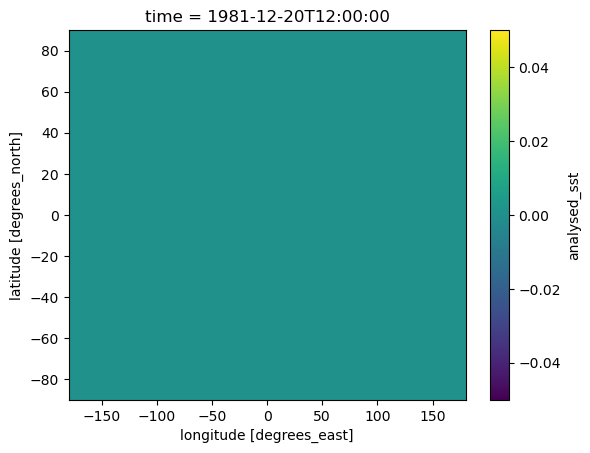

In [17]:
(sst_daily_da.sel(time='1981-12-20')==271.35).plot()

The produce includes an error field, this looks ok :

In [18]:
sst_daily_da.sel(time='1981-12-20').analysis_error.plot()

AttributeError: 'DataArray' object has no attribute 'analysis_error'

Comparing SST to the sea ice extent shows that some areas within the MIZ and in polynias are reporting 'real' SSTs, so it looks like these could be useful observations

In [ ]:
plt.figure()
plt.subplot(projection=ccrs.SouthPolarStereo())

to_plot = sst_daily_ds.sel(time='1981-12-20') ;

plt.contourf(
    to_plot.lon, 
    to_plot.lat,
    to_plot.isel(time=0).analysed_sst,
    levels=np.arange(271.35,278.2,0.5),
    cmap='cool',
    transform=ccrs.PlateCarree(),
    # vmin=271.35,
    # vmax=278.15
)

plt.colorbar()

cs=plt.contour(  
    to_plot.lon, 
    to_plot.lat,
    to_plot.isel(time=0).analysed_sst,
    [271.4],
    colors=['black'],
    transform=ccrs.PlateCarree(),
)
cs.collections[0].set_label('minimum SST')

cs=plt.contour(
    to_plot.lon, 
    to_plot.lat,
    to_plot.isel(time=0).sea_ice_fraction,
    [0.15,0.80],
    linestyles='solid',
    colors=['orange','yellow'],
    transform=ccrs.PlateCarree(),
)
cs.collections[0].set_label('15%')
cs.collections[1].set_label('80%')

plt.legend()

# Climatology

for MONTH in np.arange(1,13,1):

    to_plot=climat_sst_ds.sel(month=MONTH).ave

    
    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())


    plt.pcolormesh(
        to_plot.lon, 
        to_plot.lat, 
        to_plot,
        transform=ccrs.PlateCarree(),
        vmin=273, vmax=278,
        shading='gouraud'
    )

    ax.coastlines()

    plt.colorbar(label='SST (K)')

    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -60], crs=ccrs.PlateCarree())

    add_south_pole_gridlines(ax)
    
    #plt.title(f'Chlor_a conc {months[MONTH-1]} average')
    
    plt.show()
    
    

# Map files

Going to convert to south polar stereo and make geotiffs

In [ ]:
src_geobox=odc.geo.geobox.GeoBox.from_bbox(
    [-180,-90,180,90],
    "epsg:4326",
    shape=[3600,7200]
    )

In [ ]:
src_geobox

In [ ]:
map_geobox = odc.geo.geobox.GeoBox.from_bbox(
    [-4500000,-4500000,4500000,4500000],
    "epsg:3976",
    resolution=10000
    )

In [ ]:
map_geobox

In [ ]:
map_geobox.extent.exterior.to_crs("epsg:4326").points[:3]

In [ ]:
newNd = np.ndarray([900,900])

In [ ]:
START_YEAR='1980'

In [ ]:
datetimes_xr=sst_monthly_da.sel(time=slice(START_YEAR,'2050')).time

In [36]:
for iTime in datetimes_xr[-3:-1]:
    odc.geo.xr.rio_reproject(
        sst_monthly_da.sel(time=iTime, drop=True).values[-1:0:-1],
        newNd,
        src_geobox,
        map_geobox,
        'bilinear',
    )

    new_xr=odc.geo.xr.wrap_xr(
        newNd,
        map_geobox
    )

    write_cog(
        new_xr,
        f'{_data_dir}tracker_data/sst_cog/sst_{iTime.dt.year.values}_{iTime.dt.month.values}.tiff',
        overwrite=True
    )

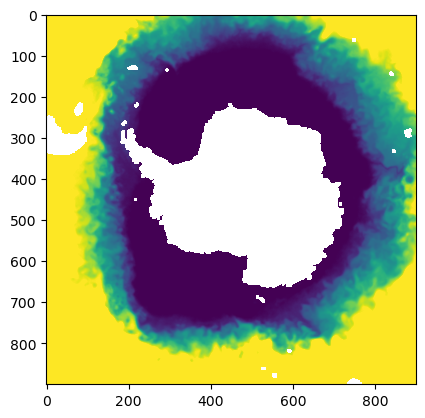

In [37]:
plt.imshow(newNd, vmin=-1.8,vmax=5)

In [ ]:
for iTime in datetimes_xr[:-1]:
    odc.geo.xr.rio_reproject(
        anoms_da.sel(time=iTime, drop=True).values[-1:0:-1],
        newNd,
        src_geobox,
        map_geobox,
        'bilinear',
    )

    new_xr=odc.geo.xr.wrap_xr(
        newNd,
        map_geobox
    )

    write_cog(
        new_xr,
        f'{_data_dir}tracker_data/sst_anoms_cog/sst_anoms_{iTime.dt.year.values}_{iTime.dt.month.values}.tiff',
        overwrite=True,
        overview_levels=[2,4]
    )